In [1]:
import numpy as np
from scipy import linalg
import scipy.sparse as sp
import scipy.sparse.linalg
from tqdm import tqdm
import matplotlib.pyplot as plt

from pyps import Basis, Hamiltonian
from pyps.constants import e, a0, En_h

In [2]:
H = Hamiltonian(
    Basis.create(n_values=range(30, 40), MJ_values=[0]),
    upper=True,
    numerov=True,
    sparse_format="csr",
)

# compute Stark matrix
H.stark(Fz=1.0)

Stark (numerov): 100%|██████████████████████| 1360/1360 [00:35<00:00, 37.80it/s]


<1360x1360 sparse matrix of type '<class 'numpy.float64'>'
	with 31900 stored elements in Compressed Sparse Row format>

eigenenergies: 100%|████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


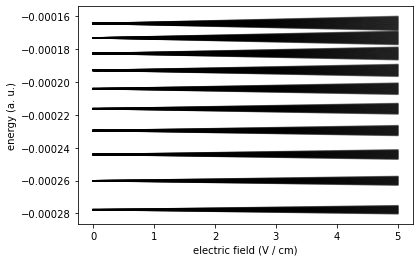

In [3]:
field = np.linspace(0.0, 5.0, 20)  # V/cm

sm = H.stark_map(100.0 * field)

# plot
for level in sm.T:
    plt.plot(field, level, c="k", alpha=0.1)

plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

Running `H.stark_map()` is essentially equivilent to: 

100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


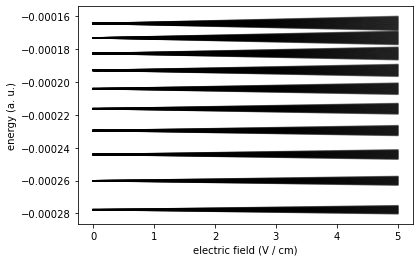

In [4]:
field_au = 100.0 * field * e * a0 / En_h  # atomic units

stark_map = np.array([linalg.eigvalsh(H.total(Fz=f).toarray()) for f in tqdm(field_au)])

# plot
for level in stark_map.T:
    plt.plot(field, level, c="k", alpha=0.1)

plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

In [5]:
%timeit linalg.eigvalsh(H.total(Fz=2.5e-10).toarray())

540 ms ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sometimes a large basis is required even if only a fraction of the eigenvalues are of interest. Fortunately, it is possible to compute a subset of the eignevalues.  This usually requires less memory.  If the subset is small, the sparse calculation is often faster too.

100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]


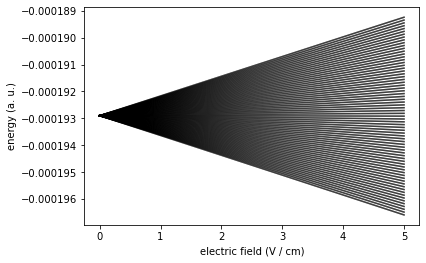

In [6]:
subset = list(H.basis.argwhere(lambda x: x.n == 36))
num_states = len(subset)
e0 = np.median(H.e0().diagonal()[subset])

sparse_map = np.array(
    [
        sp.linalg.eigsh(
            H.total(Fz=f), k=num_states, sigma=e0, return_eigenvectors=False
        )
        for f in tqdm(field_au)
    ]
)

# plot
for level in sparse_map.T:
    plt.plot(field, level, c="k", alpha=0.5)

plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

Compare sparse and dense calculations:

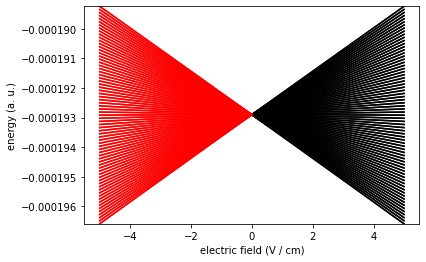

In [7]:
# dense
for i in subset:
    plt.plot(field, stark_map[:, i], c="k")

# sparse
for level in sparse_map.T:
    plt.plot(-field, level, c="r")

plt.ylim(np.min(sparse_map), np.max(sparse_map))
plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

Note, if the subset contains a partial $n$ manifold, which eigenvalues are computed can vary abruptly from one field to the next.  This can get confusing when attempting to trace states through crossings.

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 36.88it/s]


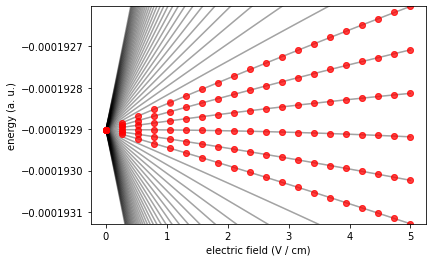

In [8]:
num_states = 12
sparse_map_12 = np.array(
    [
        sp.linalg.eigsh(
            H.total(Fz=f), k=num_states, sigma=e0, return_eigenvectors=False
        )
        for f in tqdm(field_au)
    ]
)


# dense
for i in subset:
    plt.plot(field, stark_map[:, i], c="k", alpha=0.2)

# sparse
for level in sparse_map_12.T:
    plt.plot(field, level, c="r", ls="", marker="o", alpha=0.5)

plt.ylim(np.min(sparse_map_12), np.max(sparse_map_12))
plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

In [9]:
%timeit sp.linalg.eigsh(H.total(Fz=2.5e-10), k=num_states, sigma=e0, return_eigenvectors=False)

33.3 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


However, the sparse calculation cannot compute all of the eigenvectors (`k < num_states`).  If a sizable fraction of the eigenvalues are required, it is much faster to use a dense matrix.

In [10]:
# dense
%time linalg.eigvalsh(H.total(Fz=2.5e-10).toarray())

CPU times: user 865 ms, sys: 51.7 ms, total: 916 ms
Wall time: 497 ms


array([-0.00027843, -0.00027843, -0.00027841, ..., -0.00016328,
       -0.00016325, -0.00016325])

In [11]:
# sparse
k = H.basis.num_states - 1
%time sp.linalg.eigsh(H.total(Fz=2.5e-10), k=k, return_eigenvectors=False)

CPU times: user 7.27 s, sys: 261 ms, total: 7.53 s
Wall time: 4.76 s


array([-0.00016325, -0.00016328, -0.00016328, ..., -0.00027841,
       -0.00027843, -0.00027843])